In [ ]:
# Installing dependecies
# ! pip install -U tensorly
# ! pip install git+https://github.com/ahwillia/tensortools
# ! pip install tensorflow

## 1. Data Preparation
### 1.1  Libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import FactorAnalysis, PCA

import tensortools as tt
from tensortools.operations import unfold as tt_unfold, khatri_rao

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac

import tensorflow as tf

# import some useful functions (they are available in utils.py)
from utils import *

### 1.2 Reading Data

In [2]:
# Reading data 
speed_df = pd.read_csv('weekdays.csv')
print("Shape of original table", speed_df.shape)

Shape of original table (4651200, 4)


### 1.3 Pre-processing steps

In [3]:
# Missing values
speed_df.isna().sum()

time     0
date     0
Link     0
Speed    0
dtype: int64

In [4]:
speed_df.head()

,time,date,Link,Speed
0,18:00:00,2017-01-05,207-1,8.0
1,17:30:00,2017-01-05,207-1,9.6
2,17:45:00,2017-01-05,203-1,9.6
3,17:45:00,2017-01-05,207-1,9.6
4,16:30:00,2017-01-05,203-1,11.2


In [5]:
# speed_df.head()

# Time bins - Weekdays:96
# sorted(speed_df.time.unique())
n_time = len(speed_df.time.unique())

# Dates - Weekdays:170
# sorted(speed_df.date.unique())
n_date = len(speed_df.date.unique())

# Links - Weekdays:285
# sorted(speed_df.Link.unique()
n_link = len(speed_df.Link.unique())

print('Number of Time Bins:', n_time)
print('Number of Days:', n_date)
print('Number of Links:', n_link)

Number of Time Bins: 96
Number of Days: 170
Number of Links: 285


In [6]:
# Mapping link IDs to numbers
link_mapping = dict(zip(sorted(speed_df.Link.unique()), range(1,len(speed_df.Link.unique())+1)))
speed_df.Link = speed_df.Link.map(link_mapping)

In [7]:
pivot_df = speed_df.pivot(index =['date','Link'], columns=['time'], values = ['Speed'])
print("Shape of pivoted table", pivot_df.shape)

Shape of pivoted table (48450, 96)


In [8]:
pivot_df

Speed                                               \
time            00:00:00 00:15:00 00:30:00 00:45:00 01:00:00 01:15:00   
date       Link                                                         
2017-01-02 1       108.8    108.8    110.4    108.8    108.8    110.4   
           2       112.0    110.4    113.6    112.0    113.6    113.6   
           3       110.4    110.4    113.6    113.6    113.6    113.6   
           4       105.6    105.6    105.6    105.6    105.6    105.6   
           5       108.8    107.2    108.8    107.2    105.6    105.6   
...                  ...      ...      ...      ...      ...      ...   
2017-08-25 281     105.6    108.8    107.2    107.2    108.8    107.2   
           282     113.6    112.0    112.0    115.2    115.2    115.2   
           283     102.4    102.4    100.8    100.8    100.8    100.8   
           284      96.0     96.0     96.0     97.6     97.6     97.6   
           285     108.8    108.8    107.2    107.2    105.6    110.4   

                                                     ...                    \
time            01:30:00 01:45:00 02:00:00 02:15:00  ... 21:30:00 21:45:00   
date       Link                                      ...                     
2017-01-02 1       110.4    112.0    108.8    110.4  ...    105.6    105.6   
           2       110.4    112.0    108.8    112.0  ...    107.2    110.4   
           3       115.2    115.2    118.4    118.4  ...    110.4    112.0   
           4       104.0    105.6    102.4    105.6  ...    100.8    102.4   
           5       105.6    107.2    105.6    105.6  ...    104.0    105.6   
...                  ...      ...      ...      ...  ...      ...      ...   
2017-08-25 281     108.8    108.8    108.8    104.0  ...     99.2    100.8   
           282     115.2    116.8    116.8    116.8  ...    108.8    110.4   
           283     104.0    102.4    100.8    104.0  ...     92.8     96.0   
           284      97.6     97.6     97.6     97.6  ...     91.2     92.8   
           285     108.8    108.8    108.8    112.0  ...     68.8     68.8   

                                                                       \
time            22:00:00 22:15:00 22:30:00 22:45:00 23:00:00 23:15:00   
date       Link                                                         
2017-01-02 1       104.0    102.4    102.4    102.4    104.0    105.6   
           2       112.0    112.0    108.8    108.8    112.0    108.8   
           3       112.0    112.0    112.0    110.4    113.6    112.0   
           4       104.0    104.0    102.4    102.4    105.6    104.0   
           5       105.6    105.6    107.2    107.2    107.2    107.2   
...                  ...      ...      ...      ...      ...      ...   
2017-08-25 281     104.0    100.8    104.0    102.4    102.4    104.0   
           282     110.4    108.8    107.2    108.8    112.0    110.4   
           283      99.2     96.0     96.0     97.6     99.2     97.6   
           284      92.8     92.8     94.4     92.8     94.4     94.4   
           285      68.8     68.8     68.8     68.8     68.8     68.8   

                                   
time            23:30:00 23:45:00  
date       Link                    
2017-01-02 1       105.6    105.6  
           2       110.4    112.0  
           3       112.0    113.6  
           4       105.6    105.6  
           5       108.8    107.2  
...                  ...      ...  
2017-08-25 281     104.0    105.6  
           282     107.2    107.2  
           283      91.2     41.6  
           284      94.4     94.4  
           285      68.8     68.8  

[48450 rows x 96 columns]

In [9]:
# Check the sizes
print('Length of Days OK:', pivot_df.shape[0]/n_link == n_date)
print('Length of Links OK:', pivot_df.shape[0]/n_date == n_link)

# Check how many Links for each Date?
if (pivot_df.reset_index()[['date', 'Link']].groupby('date').agg('count').Link.unique()[0] == n_link):
    print('Links per Day:', pivot_df.reset_index()[['date', 'Link']].groupby('date').agg('count').Link.unique())
else:
    print('Check Links per Day')

# sorting dataframe
pivot_df = pivot_df.sort_values(by=['date', 'Link'])

Length of Days OK: True
Length of Links OK: True
Links per Day: [285]


C:\Users\Reyash\anaconda3\lib\site-packages\pandas\core\generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## 2. CP Decomposition

### 2.1 Tensor definition

In [12]:
# test_df = pivot_df.reset_index()
pivot_arr = pivot_df.to_numpy()
print("Shape of pivoted array", pivot_arr.shape)

tensor_arr = pivot_arr.reshape(n_date, n_link, n_time)
print("Shape of Tensor array", tensor_arr.shape)

Shape of pivoted array (48450, 96)
Shape of Tensor array (170, 285, 96)


In [13]:
# tensor_arr

#### All time bins
##### Rank 3 - Decomposition

CP_ALS: iteration 1, objective 0.10855689329123326, improvement inf.
CP_ALS: iteration 2, objective 0.09526143516497668, improvement 0.013295458126256585.
CP_ALS: iteration 3, objective 0.09478006741570205, improvement 0.0004813677492746249.
CP_ALS: iteration 4, objective 0.09477579016556248, improvement 4.277250139572697e-06.
Converged after 4 iterations, 0.21709889999999987 seconds. Objective: 0.09477579016556248.
CP_ALS: iteration 1, objective 0.10007810854368096, improvement inf.
CP_ALS: iteration 2, objective 0.09485850068150128, improvement 0.005219607862179676.
CP_ALS: iteration 3, objective 0.09479384176033619, improvement 6.465892116509775e-05.
CP_ALS: iteration 4, objective 0.09478104093290998, improvement 1.2800827426204253e-05.
CP_ALS: iteration 5, objective 0.094777424933479, improvement 3.6159994309808985e-06.
Converged after 5 iterations, 0.29638989999999765 seconds. Objective: 0.094777424933479.
CP_ALS: iteration 1, objective 0.10284458914054792, improvement inf.
CP_ALS

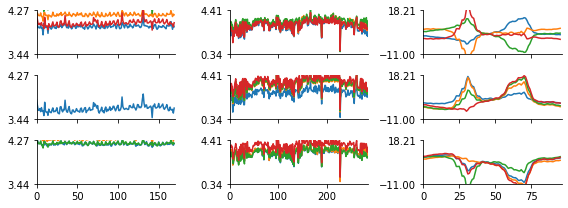

In [14]:
# Number of components
R = 4

# Fit CP tensor decomposition
# U = tt.cp_als(tensor_arr, rank=4, verbose=True)
V1 = tt.cp_als(tensor_arr, rank=3, verbose=True, init = 'rand')
# More attempts to see the randomness of fit
V2 = tt.cp_als(tensor_arr, rank=3, verbose=True, init = 'rand')
V3 = tt.cp_als(tensor_arr, rank=3, verbose=True, init = 'rand')
V4 = tt.cp_als(tensor_arr, rank=3, verbose=True, init = 'rand')

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(V1.factors)
tt.plot_factors(V2.factors, fig = fig)
tt.plot_factors(V3.factors, fig = fig)
tt.plot_factors(V4.factors, fig = fig)
fig.tight_layout()

# Show plots.
plt.show()

###### Rank 2 - Decomposition

CP_ALS: iteration 1, objective 0.10120744364005259, improvement inf.
CP_ALS: iteration 2, objective 0.09769767318207645, improvement 0.0035097704579761385.
CP_ALS: iteration 3, objective 0.09766049596134493, improvement 3.717722073151575e-05.
CP_ALS: iteration 4, objective 0.09765971840187841, improvement 7.775594665221375e-07.
Converged after 4 iterations, 0.38285439999890514 seconds. Objective: 0.09765971840187841.
CP_ALS: iteration 1, objective 0.1109391996016005, improvement inf.
CP_ALS: iteration 2, objective 0.10150098856374873, improvement 0.009438211037851765.
CP_ALS: iteration 3, objective 0.09782470714938928, improvement 0.003676281414359453.
CP_ALS: iteration 4, objective 0.09766166146272949, improvement 0.00016304568665978514.
CP_ALS: iteration 5, objective 0.09765610042755817, improvement 5.561035171325335e-06.
Converged after 5 iterations, 0.45214059999852907 seconds. Objective: 0.09765610042755817.
CP_ALS: iteration 1, objective 0.09997696043602937, improvement inf.
CP_A

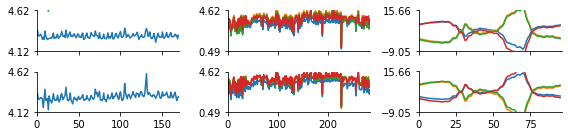

In [131]:
# Fit CP tensor decomposition
U1 = tt.cp_als(tensor_arr, rank=2, verbose=True, init = 'rand')
# More attempts to see the randomness of fit
U2 = tt.cp_als(tensor_arr, rank=2, verbose=True, init = 'rand')
U3 = tt.cp_als(tensor_arr, rank=2, verbose=True, init = 'rand')
U4 = tt.cp_als(tensor_arr, rank=2, verbose=True, init = 'rand')

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U1.factors)
tt.plot_factors(U2.factors, fig = fig)
tt.plot_factors(U3.factors, fig = fig)
tt.plot_factors(U4.factors, fig = fig)
# fig.tight_layout()

# Show plots.
plt.show()

(<Figure size 576x216 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 array([[<matplotlib.collections.PathCollection object at 0x000001F716D94700>,
         <BarContainer object of 285 artists>,
         list([<matplotlib.lines.Line2D object at 0x000001F71D596040>])],
         <BarContainer object of 285 artists>,
         list([<matplotlib.lines.Line2D object at 0x000001F71D8A8F40>])],
         <BarContainer object of 285 artists>,
         list([<matplotlib.lines.Line2D object at 0x000001F716D2C610>])]],
       dtype=object))

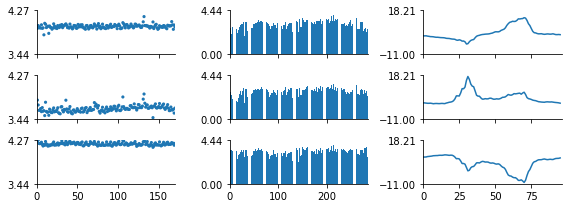

In [19]:
tt.plot_factors(V1.factors, plots = ['scatter', 'bar', 'line'])

In [69]:
print('tensor shape', tensor_arr.shape)
print('reconstructed tensor shape', reconstruct(V1.factors).shape)

tensor shape (170, 285, 96)
reconstructed tensor shape (170, 285, 96)


In [134]:
# let's look at the similarity - Close for all trials
print(tensor_arr[0])
print(reconstruct(V2.factors)[0])

[[108.8 108.8 110.4 ... 105.6 105.6 105.6]
 [112.  110.4 113.6 ... 108.8 110.4 112. ]
 [110.4 110.4 113.6 ... 112.  112.  113.6]
 ...
 [102.4 102.4 102.4 ... 102.4 102.4 102.4]
 [ 86.4  84.8  84.8 ...  88.   86.4  81.6]
 [107.2 110.4 110.4 ... 108.8 110.4 108.8]]
[[109.27578735 109.24930191 109.07374954 ... 106.86741257 106.81068802
  107.35118484]
 [108.38551712 108.32728577 108.2878952  ... 106.977211   107.08586121
  107.5685463 ]
 [107.95572662 108.00174713 107.82986069 ... 103.29488945 103.20795822
  104.27544785]
 ...
 [102.36223602 102.38848877 102.2032547  ...  98.49734497  98.39792061
   99.25202942]
 [ 90.2010498   90.12877274  89.99207687 ...  89.80454636  89.78969193
   89.87576294]
 [108.29903793 108.35019684 108.14159012 ... 103.47398949 103.34414101
  104.40286255]]


In [133]:
tensor = tf.convert_to_tensor(tensor_arr)
reconstructed_tensor = tf.convert_to_tensor(reconstruct(V2.factors)[0])

normalize_a = tf.nn.l2_normalize(tensor, 0)        
normalize_b = tf.nn.l2_normalize(reconstructed_tensor, 0)

cos_similarity = tf.reduce_sum(tf.multiply(normalize_a, normalize_b))
cos_similarity

<tf.Tensor: shape=(), dtype=float64, numpy=20804.257412813295>

In [140]:
trial_list = [V1.factors, V2.factors, V3.factors, V4.factors]
reconstruct_errors = []
similarities = []
for each in trial_list:
    magnitude = np.sum(tensor_arr)
    reconstruct_error = np.sum((tensor_arr - reconstruct(each.factors))**2)/magnitude
    reconstruct_errors.append(reconstruct_error)
np.mean(reconstruct_errors)

0.9367619496329879

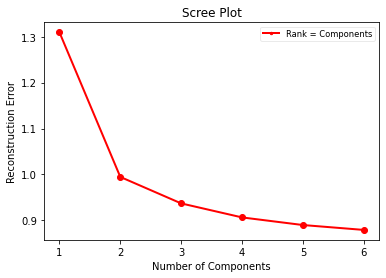

In [160]:
def Scree_plot(tensor, max_rank, verbose = False):
    reconstruct_errors = []
    for R in range(1, max_rank):
        U = tt.cp_als(tensor, rank=R, verbose=verbose, init = 'rand')
        # calculate reconstruction errors
        magnitude = np.sum(tensor)
        reconstruct_error = np.sum((tensor - reconstruct(U.factors))**2)/magnitude
        reconstruct_errors.append(reconstruct_error)
    # Plot
    plt.plot(np.array([i for i in range(1,max_rank)]), np.array(reconstruct_errors),  'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    leg = plt.legend(['Rank = Components'], loc='best', borderpad=0.3, 
                     shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)
    plt.show()
    
Scree_plot(tensor = tensor_arr, max_rank = 7, verbose = False)

In [154]:
np.array(reconstruct_errors)
np.array([i for i in range(1,13)])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

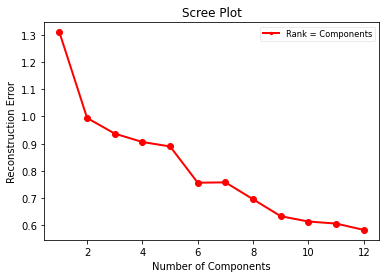

In [36]:
def soft_cluster_factor(factor):
    """Returns soft-clustering of data based on CP decomposition results.
    Parameters
    ----------
    data : ndarray, N x R matrix of nonnegative data
        Datapoints are held in rows, features are held in columns
    Returns
    -------
    cluster_ids : ndarray, vector of N integers in range(0, R)
        List of soft cluster assignments for each row of data matrix
    perm : ndarray, vector of N integers
        Permutation / ordering of the rows of data induced by the soft
        clustering.
    """

    # copy factor of interest
    f = np.copy(factor)

    # cluster based on score of maximum absolute value
    cluster_ids = np.argmax(np.abs(f), axis=1)
    scores = f[range(f.shape[0]), cluster_ids]

    # resort within each cluster
    perm = []
    for cluster in np.unique(cluster_ids):
        idx = np.where(cluster_ids == cluster)[0]
        perm += list(idx[np.argsort(scores[idx])][::-1])

    return cluster_ids, perm

In [58]:
ids, perm = soft_cluster_factor(V1.factors[1])

In [59]:
from collections import Counter
Counter(ids)
# Counter(perm)

Counter({2: 233, 0: 51, 1: 1})

##### Time bins (1PM - 7PM)

In [39]:
# check for nulls
pivot_arr[pivot_arr == np.nan]
pivot_df.columns[52:76]


MultiIndex([('Speed', '13:00:00'),
            ('Speed', '13:15:00'),
            ('Speed', '13:30:00'),
            ('Speed', '13:45:00'),
            ('Speed', '14:00:00'),
            ('Speed', '14:15:00'),
            ('Speed', '14:30:00'),
            ('Speed', '14:45:00'),
            ('Speed', '15:00:00'),
            ('Speed', '15:15:00'),
            ('Speed', '15:30:00'),
            ('Speed', '15:45:00'),
            ('Speed', '16:00:00'),
            ('Speed', '16:15:00'),
            ('Speed', '16:30:00'),
            ('Speed', '16:45:00'),
            ('Speed', '17:00:00'),
            ('Speed', '17:15:00'),
            ('Speed', '17:30:00'),
            ('Speed', '17:45:00'),
            ('Speed', '18:00:00'),
            ('Speed', '18:15:00'),
            ('Speed', '18:30:00'),
            ('Speed', '18:45:00')],
           names=[None, 'time'])

In [41]:
ncol = 24
tensor_arr2 = pivot_arr[:, 52:76].reshape(n_date, n_link, ncol)
tensor_arr2.shape

(170, 285, 24)

###### Rank 2 - Decomposition

CP_ALS: iteration 1, objective 0.12872636422694725, improvement inf.
CP_ALS: iteration 2, objective 0.12274594158947202, improvement 0.0059804226374752245.
CP_ALS: iteration 3, objective 0.1197689329835145, improvement 0.0029770086059575235.
CP_ALS: iteration 4, objective 0.11960379957842923, improvement 0.00016513340508526875.
CP_ALS: iteration 5, objective 0.11959733691179765, improvement 6.462666631582015e-06.
Converged after 5 iterations, 0.428701099997852 seconds. Objective: 0.11959733691179765.
CP_ALS: iteration 1, objective 0.1280714863677691, improvement inf.
CP_ALS: iteration 2, objective 0.11967220366749887, improvement 0.008399282700270239.
CP_ALS: iteration 3, objective 0.119582175600085, improvement 9.002806741387204e-05.
CP_ALS: iteration 4, objective 0.11958027648654913, improvement 1.899113535860919e-06.
Converged after 4 iterations, 0.2966632000025129 seconds. Objective: 0.11958027648654913.
CP_ALS: iteration 1, objective 0.12169726064973473, improvement inf.
CP_ALS: i

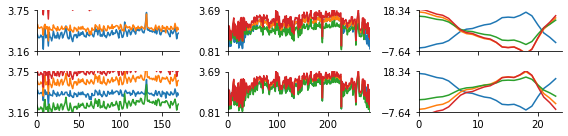

In [42]:
# Fit CP tensor decomposition
X1 = tt.cp_als(tensor_arr2, rank=2, verbose=True, init = 'rand')
# More attempts to see the randomness of fit
X2 = tt.cp_als(tensor_arr2, rank=2, verbose=True, init = 'rand')
X3 = tt.cp_als(tensor_arr2, rank=2, verbose=True, init = 'rand')
X4 = tt.cp_als(tensor_arr2, rank=2, verbose=True, init = 'rand')

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(X1.factors)
tt.plot_factors(X2.factors, fig = fig)
tt.plot_factors(X3.factors, fig = fig)
tt.plot_factors(X4.factors, fig = fig)
# fig.tight_layout()
# Show plots.
plt.show()

##### Rank 3 - Decomposition

CP_ALS: iteration 1, objective 0.11958005070231066, improvement inf.
CP_ALS: iteration 2, objective 0.11788505323365595, improvement 0.001694997468654716.
CP_ALS: iteration 3, objective 0.11762799707855369, improvement 0.000257056155102256.
CP_ALS: iteration 4, objective 0.11758404491858733, improvement 4.395215996635948e-05.
CP_ALS: iteration 5, objective 0.11757561625097881, improvement 8.428667608514906e-06.
Converged after 5 iterations, 0.3017037000026903 seconds. Objective: 0.11757561625097881.
CP_ALS: iteration 1, objective 0.12013574370663459, improvement inf.
CP_ALS: iteration 2, objective 0.11769434225472815, improvement 0.0024414014519064386.
CP_ALS: iteration 3, objective 0.11758837211315748, improvement 0.00010597014157066875.
CP_ALS: iteration 4, objective 0.11757214840170237, improvement 1.622371145511281e-05.
CP_ALS: iteration 5, objective 0.11756856838342608, improvement 3.5800182762862898e-06.
Converged after 5 iterations, 0.3595592999990913 seconds. Objective: 0.11756

(<Figure size 576x216 with 9 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 array([[list([<matplotlib.lines.Line2D object at 0x000001C91385A4F0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913846B50>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913866340>])],
        [list([<matplotlib.lines.Line2D object at 0x000001C9138665B0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C9138667C0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913866A90>])],
        [list([<matplotlib.lines.Line2D object at 0x000001C913866D00>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913866F70>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913872220>])]],
       dtype=object))

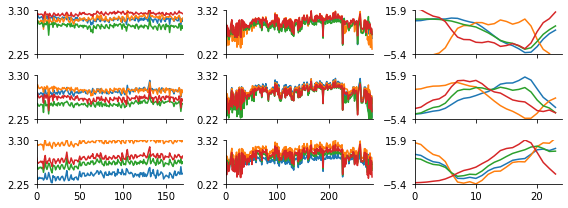

In [43]:
# Fit CP tensor decomposition
Y1 = tt.cp_als(tensor_arr2, rank=3, verbose=True, init = 'rand')
# More attempts to see the randomness of fit
Y2 = tt.cp_als(tensor_arr2, rank=3, verbose=True, init = 'rand')
Y3 = tt.cp_als(tensor_arr2, rank=3, verbose=True, init = 'rand')
Y4 = tt.cp_als(tensor_arr2, rank=3, verbose=True, init = 'rand')

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(Y1.factors)
tt.plot_factors(Y2.factors, fig = fig)
tt.plot_factors(Y3.factors, fig = fig)
tt.plot_factors(Y4.factors, fig = fig)
# fig.tight_layout()
# Show plots.


##### Rank 4 - Decomposition

CP_ALS: iteration 1, objective 0.11825733298190749, improvement inf.
CP_ALS: iteration 2, objective 0.11687677631701847, improvement 0.0013805566648890238.
CP_ALS: iteration 3, objective 0.11684605206218607, improvement 3.072425483240104e-05.
CP_ALS: iteration 4, objective 0.1168295482730608, improvement 1.6503789125266177e-05.
CP_ALS: iteration 5, objective 0.11681324270743428, improvement 1.6305565626525964e-05.
CP_ALS: iteration 6, objective 0.1167938637097273, improvement 1.9378997706973045e-05.
CP_ALS: iteration 7, objective 0.11676773629219567, improvement 2.6127417531635055e-05.
CP_ALS: iteration 8, objective 0.11672643310230807, improvement 4.130318988759818e-05.
CP_ALS: iteration 9, objective 0.11664372553622182, improvement 8.270756608624863e-05.
CP_ALS: iteration 10, objective 0.11640887847118583, improvement 0.00023484706503598685.
CP_ALS: iteration 11, objective 0.11547241497994182, improvement 0.0009364634912440162.
CP_ALS: iteration 12, objective 0.11363303611783142, imp

CP_ALS: iteration 33, objective 0.1082099871565283, improvement 0.00011564346008594018.
CP_ALS: iteration 34, objective 0.10806194191846477, improvement 0.00014804523806352665.
CP_ALS: iteration 35, objective 0.10789999024024235, improvement 0.00016195167822241618.
CP_ALS: iteration 36, objective 0.10775247109755025, improvement 0.00014751914269210686.
CP_ALS: iteration 37, objective 0.10763475660867793, improvement 0.0001177144888723225.
CP_ALS: iteration 38, objective 0.10754550999145318, improvement 8.92466172247447e-05.
CP_ALS: iteration 39, objective 0.10747783797605433, improvement 6.767201539885359e-05.
CP_ALS: iteration 40, objective 0.1074256243949691, improvement 5.221358108523089e-05.
CP_ALS: iteration 41, objective 0.10738451263471369, improvement 4.1111760255410634e-05.
CP_ALS: iteration 42, objective 0.10735149223537228, improvement 3.3020399341401885e-05.
CP_ALS: iteration 43, objective 0.10732444926592923, improvement 2.7042969443058507e-05.
CP_ALS: iteration 44, object

CP_ALS: iteration 22, objective 0.10831383129983127, improvement 0.00018310480595221112.
CP_ALS: iteration 23, objective 0.10799750688260822, improvement 0.0003163244172230545.
CP_ALS: iteration 24, objective 0.10748088586248838, improvement 0.0005166210201198312.
CP_ALS: iteration 25, objective 0.10693255412788448, improvement 0.0005483317346039046.
CP_ALS: iteration 26, objective 0.10664069684351693, improvement 0.0002918572843675499.
CP_ALS: iteration 27, objective 0.10650695587948217, improvement 0.000133740964034762.
CP_ALS: iteration 28, objective 0.106425015872797, improvement 8.194000668516888e-05.
CP_ALS: iteration 29, objective 0.1063626969372426, improvement 6.231893555440349e-05.
CP_ALS: iteration 30, objective 0.106308787332307, improvement 5.390960493559249e-05.
CP_ALS: iteration 31, objective 0.10625859955913125, improvement 5.018777317575274e-05.
CP_ALS: iteration 32, objective 0.10620959605850912, improvement 4.900350062213288e-05.
CP_ALS: iteration 33, objective 0.106

CP_ALS: iteration 59, objective 0.10695718857384615, improvement 0.00017851762056551868.
CP_ALS: iteration 60, objective 0.10679418403967461, improvement 0.0001630045341715347.
CP_ALS: iteration 61, objective 0.10665560611372342, improvement 0.00013857792595119156.
CP_ALS: iteration 62, objective 0.1065421411524097, improvement 0.00011346496131371675.
CP_ALS: iteration 63, objective 0.10644973917838015, improvement 9.24019740295573e-05.
CP_ALS: iteration 64, objective 0.10637358773498075, improvement 7.615144339939706e-05.
CP_ALS: iteration 65, objective 0.10630981233065194, improvement 6.377540432880857e-05.
CP_ALS: iteration 66, objective 0.10625560651458836, improvement 5.420581606357944e-05.
CP_ALS: iteration 67, objective 0.10620890061467822, improvement 4.6705899910140514e-05.
CP_ALS: iteration 68, objective 0.1061680378113643, improvement 4.0862803313918006e-05.
CP_ALS: iteration 69, objective 0.10613153760485489, improvement 3.6500206509415545e-05.
CP_ALS: iteration 70, objecti

(<Figure size 576x288 with 12 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 array([[list([<matplotlib.lines.Line2D object at 0x000001C913B4FEB0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913B962E0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913BC5280>])],
        [list([<matplotlib.lines.Line2D object at 0x000001C913BC54F0>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913BC5700>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913BC59D0>])],
        [list([<matplotlib.lines.Line2D object at 0x000001C913BC5C40>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913BC5E50>]),
         list([<matplotlib.lines.Line2D object at 0x000001C913BCE160>])],
        [list([<matplotlib.lines.Line2D object at 0x000

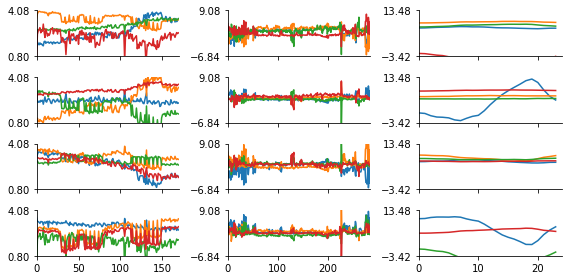

In [44]:
# Fit CP tensor decomposition
Z1 = tt.cp_als(tensor_arr2, rank=4, verbose=True, init = 'rand')
# More attempts to see the randomness of fit
Z2 = tt.cp_als(tensor_arr2, rank=4, verbose=True, init = 'rand')
Z3 = tt.cp_als(tensor_arr2, rank=4, verbose=True, init = 'rand')
Z4 = tt.cp_als(tensor_arr2, rank=4, verbose=True, init = 'rand')

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(Z1.factors)
tt.plot_factors(Z2.factors, fig = fig)
tt.plot_factors(Z3.factors, fig = fig)
tt.plot_factors(Z4.factors, fig = fig)
# fig.tight_layout()
# Show plots.


In [ ]:
# SIMILARITY OF DECOMPOSITIONS
# sim = tt.kruskal_align(V.factors, Z.factors, permute_U=True, permute_V=True)
# print("Similarity", sim)

#### Visualisations

(170, 2)
(285, 2)
(96, 2)


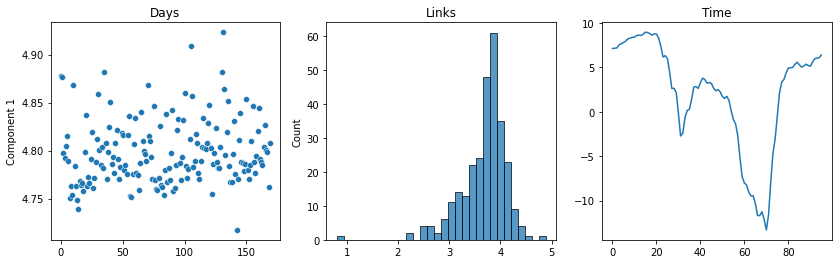

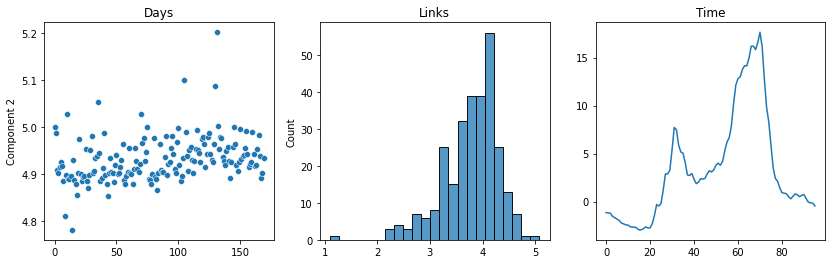

In [135]:
Days_decomp = list() # Days
Links_decomp = list() # Links
Time_decomp = list() # Time

# F = np.array()
n_comp = 3
for f in U4.factors:
#     print(f)
    # vector matrices of individual components
    print(f.shape)
    if(f.shape[0] == n_date):
        Days_decomp = [each for each in f.T]
    elif(f.shape[0] == n_link):
        Links_decomp = [each for each in f.T]
    elif(f.shape[0] == n_time):
        Time_decomp = [each for each in f.T]   
    n_comp = f.shape[1]
        
for i in range(n_comp):
    fig, axs = plt.subplots(ncols=3, figsize=(14,4))
    fig.subplots_adjust(wspace=0.2)
    sns.scatterplot(data = Days_decomp[i], ax=axs[0]).set_title("Days")
    sns.histplot(data = Links_decomp[i], ax=axs[1]).set_title("Links")
    sns.lineplot(data = Time_decomp[i], ax=axs[2]).set_title("Time")
    axs[0].set( ylabel="Component {}".format(i+1))
    plt.show()

In [161]:
Days_decomp_trials = list() # Days
Links_decomp_trials = list() # Links
Time_decomp_trials = list() # Time


trial_list = [V1.factors, V2.factors, V3.factors, V4.factors]

for each in trial_list:
    Days_decomp = list() # Days
    Links_decomp = list() # Links
    Time_decomp = list() # Time
    for f in each:
        if(f.shape[0] == n_date):
            Days_decomp = [each for each in f.T]
        elif(f.shape[0] == n_link):
            Links_decomp = [each for each in f.T]
        elif(f.shape[0] == n_time):
            Time_decomp = [each for each in f.T]   
    Days_decomp_trials.append(Days_decomp)
    Links_decomp_trials.append(Links_decomp)
    Time_decomp_trials.append(Time_decomp)
    
    n_comp = f.shape[1]
    
print(len(Days_decomp_trials), len(Links_decomp_trials), len(Time_decomp_trials))

4 4 4


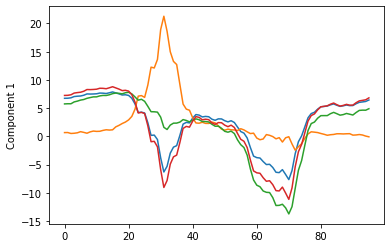

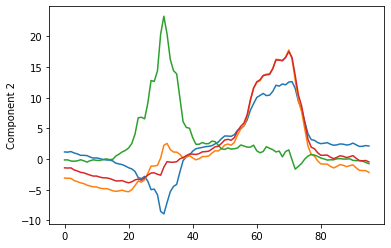

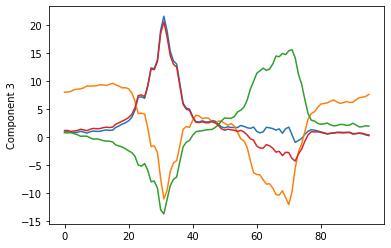

In [164]:
n_trials = 4
n_comp = 3
for j in range(n_comp):
    for i in range(n_trials):
        sns.lineplot(data = Time_decomp_trials[i][j])
#         sns.scatterplot(data = Days_decomp_trials[i][j])
    plt.ylabel("Component {}".format(j+1))
    plt.show()

## Appendix

### A1. Test for Uniqueness

In [ ]:
# Make synthetic dataset.
I, J, K, R = 25, 25, 25, 4  # dimensions and rank
X = tt.randn_ktensor((I, J, K), rank=R).full()
X += np.random.randn(I, J, K)

# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)

# Compare the low-dimensional factors from the two fits.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("raw models")
fig.tight_layout()

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print("Similarity", sim)

# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)
fig.suptitle("aligned models")
fig.tight_layout()

# Show plots.
plt.show()

In [ ]:
observed = np.load("tensor-decomposition-in-python-master/data/observed.npy")
print('Shapre of the tensor', observed.shape)

# Specify the tensor, and the rank (np. of factors)
X, rank = observed, 3

# Perform CP decompositon using TensorLy
factors_tl = parafac(X, rank=rank)

# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

# Reconstruct M, with the result of each library
# Import from utils - reconstruct, plot_factors
# M_tl = reconstruct(factors_tl)
# M_tt = reconstruct(factors_tt)

# plot the decomposed factors
# plot_factors(factors_tl)
# plot_factors(factors_tt)